# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [152]:
import numpy as np 
import matplotlib.pyplot as plt 
import math  
import time 
from numpy import linalg   
import random  

In [153]:
random.seed(42) 

In [154]:
def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

In [155]:
def RandK(percent, vector, d):   
    k = int(percent * d)
    indices = np.random.choice(d, k, replace=True) 
    new_vector = np.zeros(d) 
    new_vector[indices] = vector[indices]
    return (1/percent) * new_vector

In [156]:
def TopK(percent, vector, d):  
    k = int(percent * d)
    indices = np.argpartition(np.absolute(vector), -k)[-k:]
    new_vector = np.zeros(d) 
    new_vector[indices] = vector[indices]
    return new_vector

In [157]:
def Compression(name, percent, vector, d): 
    if(name=='RandK'): 
        return RandK(percent, vector, d) 
    elif(name=='TopK'): 
        return TopK(percent, vector, d)

In [158]:
def grad(A, b, x, d):  
    gr = np.zeros(d) 
    gr = np.dot(A, x) - b 
    return gr 

In [319]:
class GradientDescent: 
    def __init__(self, A, b, max_info, lr, workers, name, percents, d): 
        self.matrix = A 
        self.bias = b 
        self.max_info = max_info  
        self.lr = lr 
        self.x = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d)
        for i in range(0, self.max_info, self.k * self.workers):  
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)

            for j in range(self.workers): 
                h = grad(self.matrix[j], self.bias[j], self.x, self.d)  
                full_g += h   
                g += Compression(self.name, self.percents, h, self.d)  
            
            g = (1/self.workers) * g 
            full_g = (1/self.workers) * full_g  
            self.x = self.x - self.lr * g 
            self.grad_history.append(np.linalg.norm(full_g)**2)
            self.information_send.append(i + self.workers * self.k) 

In [159]:
L = 1000 
mu = 1 
d = 100 
n = 10  

A = [] 
b = []
for i in range(n): 
    A.append(generate_matrix(d, mu, L))  
    b.append(np.random.normal(d)) 

In [291]:
gd_rand_1 = GradientDescent(A, b,  10**6, 1/(4*L * (1 + 2 * 100 * 1/n)), n, 'RandK', 0.01, d)   
gd_rand_5 = GradientDescent(A, b,  10**6, 1/(4*L * (1 + 2 * 20 * 1/n)), n, 'RandK', 0.05, d) 
gd_rand_10 = GradientDescent(A, b, 10**6, 1/(4*L * (1 + 2 * 10 * 1/n)), n, 'RandK', 0.1, d) 
gd_rand_20 = GradientDescent(A, b, 10**6, 1/(4*L * (1 + 2 * 5 * 1/n)), n, 'RandK', 0.2, d)

In [292]:
gd_rand_1.fit() 
gd_rand_5.fit() 
gd_rand_10.fit() 
gd_rand_20.fit() 

In [320]:
gd_top_10 = GradientDescent(A, b, 10**6, 4/(4 * L * (1 + 2 * 10 * 1/n)), n, 'TopK', 0.1, d)
gd_top_10.fit() 

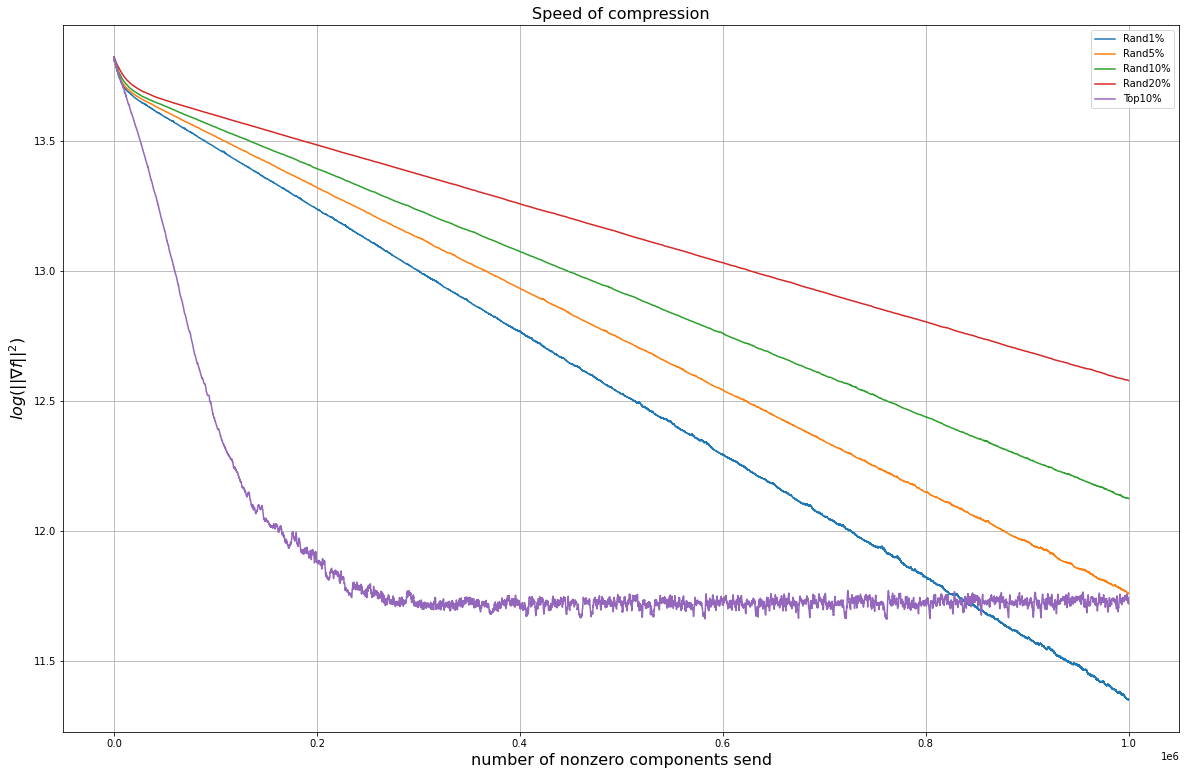

In [321]:
plt.figure(figsize=(20, 13))  
plt.title('Speed of compression', fontsize=16)  
plt.plot(gd_rand_1.information_send, np.log(gd_rand_1.grad_history), label='Rand1%') 
plt.plot(gd_rand_5.information_send, np.log(gd_rand_5.grad_history), label='Rand5%') 
plt.plot(gd_rand_10.information_send, np.log(gd_rand_10.grad_history), label='Rand10%') 
plt.plot(gd_rand_20.information_send, np.log(gd_rand_20.grad_history), label='Rand20%')  
plt.plot(gd_top_10.information_send, np.log(gd_top_10.grad_history), label='Top10%')
plt.xlabel('number of nonzero components send', fontsize=16) 
plt.ylabel(r"$log(||\nabla f||^{2})$", fontsize=16)
plt.grid() 
plt.legend() 
plt.show()

## Тяжело делать какие-то выводы, да мы видим, что сходисть линейная у каждого метода, но TopK имеет преимущество по скорости. Также стоит отметить, что из-за того что мы берем k самых больших координат, мы тем самым не можем уловить сходимость по другим координатам, поэтому остаемся на одиннаковом уровне. Можно заметить что Rand1% cходится лучше всех, так как получается у него больше итераций и как бы можно сказать, что на каждую пересылку он более информативней чем его коллеги.

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [164]:
class UpdateGradientDescent: 
    def __init__(self, A, b, max_iter, lr, workers, name, percents, d): 
        self.A = A 
        self.b = b 
        self.max_iter = max_iter  
        self.lr = lr 
        self.x = None 
        self.iteration = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d)
        for i in range(self.max_iter):  
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d)
            for j in range(self.workers): 
                h = grad(A[j], b[j], self.x, self.d) 
                full_g = full_g + h 
                g = g + Compression(self.name, self.percents, h, self.d)  
            g *= 1/self.workers 
            full_g *= 1/self.workers 
            self.x = self.x - self.lr * g
            self.grad_history.append(np.linalg.norm(full_g)**2)
            self.iteration.append(i + 1) 

In [165]:
class EFGradientDescent: 
    def __init__(self, A, b, max_iter, lr, workers, name, percents, d): 
        self.A = A 
        self.b = b 
        self.max_iter = max_iter  
        self.lr = lr 
        self.x = None 
        self.iteration = []  
        self.information_send = []
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d)
    
    def fit(self): 
        self.x = np.zeros(self.d) 
        e_help = np.zeros((self.d, self.d))
        information = 0 
        
        for i in range(self.max_iter): 
            g = np.zeros(self.d) 
            full_g = np.zeros(self.d) 
            
            for j in range(self.workers): 
                h = grad(self.A[j], self.b[j], self.x, self.d) 
                full_g += h 
                grad_update = e_help[j] + self.lr * h  
                grad_update_compression = Compression(self.name, self.percents, grad_update, self.d)
                g += grad_update_compression
                e_help[j] = grad_update - grad_update_compression  
                
            g *= 1/self.workers 
            full_g *= 1/self.workers
            self.x = self.x - g  
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += self.k * self.workers
            self.iteration.append(i+1)  

In [166]:
gd_top_10 = UpdateGradientDescent(A, b, 10**6, 1/(4 * L * (1 + 2 * 10 * 1/n)), n, 'TopK', 0.1, d) 
efgd_top_10 = EFGradientDescent(A, b, 10**6, 1/(14 * L * 2 * 10), n, 'TopK', 0.1, d) 

In [167]:
gd_top_10.fit() 
efgd_top_10.fit()

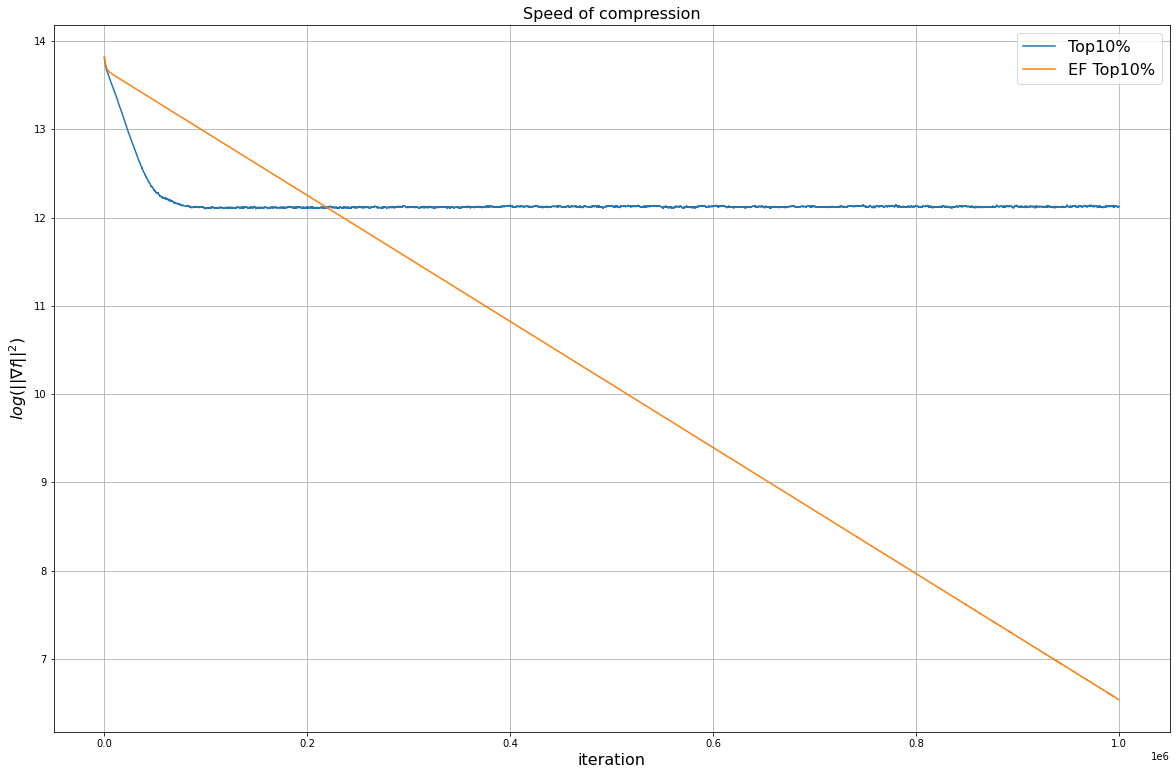

In [168]:
plt.figure(figsize=(20, 13))  
plt.title('Speed of compression', fontsize=16)  
plt.plot(gd_top_10.iteration, np.log(gd_top_10.grad_history), label='Top10%') 
plt.plot(efgd_top_10.iteration, np.log(efgd_top_10.grad_history), label='EF Top10%') 
plt.xlabel('iteration', fontsize=16) 
plt.ylabel(r"$log(||\nabla f||^{2})$", fontsize=16)
plt.grid() 
plt.legend(fontsize=16) 
plt.show()

## Видим колоссальное преимущество EF подхода над другими,  он сходится достаточно быстро,  правда требует немного больше памяти, но оно того стоило!Еще мне кажется этот метод неустойчивым, так как слишком сильно зависит от типа сжатия

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [187]:
dataset = "mushrooms.txt" 

In [188]:
from sklearn.datasets import load_svmlight_file 
from sklearn.model_selection import train_test_split 

data = load_svmlight_file(dataset)  
X, y = data[0].toarray(), data[1]  

n, d = X.shape

p = np.random.permutation(n) 

X = X[p] 
y = y[p] 

y = 2 * y - 3  

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print(X_train.shape)

(6499, 112)


In [190]:
indices = np.random.permutation(X_train.shape[0])   
X_tmp = X_train[indices]  
y_tmp = y_train[indices] 

workers_x = [] 
workers_y = [] 

batch_size = 650 
for i in range(10): 
    workers_x.append(X_tmp[i * batch_size : min((i + 1) * batch_size, X_train.shape[0])])  
    workers_y.append(y_tmp[i * batch_size : min((i + 1) * batch_size, y_train.shape[0])])

In [191]:
#теперь для каждой f_i найдем константу липишица по уже старому проверенному дедовскому методу 
#будем искать ее как максимум среди всех максимальных значений гессиана из предыдущих домашних работ 

In [371]:
maxi = -1
for i in range(10): 
    hessian = np.zeros((d, d)) 
    for j in range(workers_x[i].shape[0]): 
        hessian += np.dot(workers_x[i][j], workers_x[i][j].T) 
    hessian /= 4 * workers_x[i].shape[0]
    L = np.amax(np.linalg.eigvals(hessian))  
    if(L > maxi): 
        maxi = L 
print('L = %0.2f' % L.real)

L = 588.00


In [372]:
L = L.real 

In [373]:
reg = L/1000

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [374]:
def grad(batch_x, batch_y, batch_size, w, reg): 
    g = np.zeros(d) 
    for j in range(batch_size):  
        g = g + (-batch_y[j] * batch_x[j]) / (1 + np.exp(batch_y[j].real * np.dot(w.T, batch_x[j]))) 
    return g / batch_size + 2 * reg * w 

In [275]:
class DIANA: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg, alpha): 
        self.data_worker_x = data_worker_x 
        self.data_worker_y = data_worker_y
        self.workers = workers 
        self.lr = lr 
        self.max_iter = max_iter  
        self.name = name 
        self.percents = percents 
        self.d = d 
        self.information_send = [] 
        self.grad_history = [] 
        self.w = None 
        self.reg = reg   
        self.alpha = alpha 
        #на самом деле тут должно быть в (workers + 1) раза памяти больше ибо храним h и на сервере 
        #и на компьютерах 
        
    def fit(self, X_train, y_train): 
        self.w = np.zeros(self.d)   
        h = np.zeros((self.workers, self.d)) 
        k = int(self.percents * d) 
        information = 0 
        for i in range(self.workers): 
            h[i] = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg) 
        
        for i in range(self.max_iter):  
            g = np.zeros(self.d)  
            for j in range(self.workers): 
                delta = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, reg) 
                delta = delta - h[j]
                delta_compressed = Compression(self.name, self.percents, delta, self.d)  
                g += h[j] + delta_compressed
                h[j] += self.alpha * delta_compressed 
            
            self.w = self.w - self.lr * 1/self.workers * g
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += k * self.workers 
            self.information_send.append(information)

In [276]:
class EFGradientDescent: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg): 
        self.data_worker_x = data_worker_x
        self.data_worker_y = data_worker_y 
        self.max_iter = max_iter  
        self.lr = lr 
        self.w = None 
        self.information_send = []
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d) 
        self.reg = reg
    
    def fit(self, X_train, y_train): 
        self.w = np.zeros(self.d)
        e_help = np.zeros((self.d, self.d))
        information = 0 
        
        for i in range(self.max_iter): 
            g = np.zeros(self.d)   
            
            for j in range(self.workers): 
                h = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, self.reg) 
                grad_update = e_help[j] + self.lr * h  
                grad_update_compression = Compression(self.name, self.percents, grad_update, self.d)
                g = g + grad_update_compression
                e_help[j] = grad_update - grad_update_compression  
                
            g *= 1/self.workers 
            self.w = self.w - g   
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += self.k * self.workers
            self.information_send.append(information)  

In [277]:
class UpdateGradientDescent: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg): 
        self.data_worker_x = data_worker_x
        self.data_worker_y = data_worker_y 
        self.max_iter = max_iter  
        self.lr = lr 
        self.w = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d) 
        self.reg = reg 
    
    def fit(self, X_train, y_train): 
        self.w = np.zeros(self.d) 
        information = 0
        for i in range(self.max_iter):  
            g = np.zeros(self.d) 
            for j in range(self.workers): 
                h = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, self.reg) 
                g = g + Compression(self.name, self.percents, h, self.d)  
            g *= 1/self.workers 
            self.w = self.w - self.lr * g
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += self.k * self.workers
            self.information_send.append(information)

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [278]:
diana_top_k = DIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'TopK', 0.1, d, L/1000, 1/11) 
diana_rand_k = DIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'RandK', 0.1, d, L/1000, 1/11)

In [279]:
ef_top_k = EFGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'TopK', 0.1, d, L/1000) 
ef_rand_k = EFGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'RandK', 0.1, d, L/1000)

In [280]:
gd_top_k = UpdateGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'TopK', 0.1, d, L/1000) 
gd_rand_k = UpdateGradientDescent(workers_x, workers_y, 10, 1/(14 * L * 2 * 10), 10**2, 'RandK', 0.1, d, L/1000) 

In [281]:
diana_top_k.fit(X_train, y_train) 
diana_rand_k.fit(X_train, y_train) 

/tmp/ipykernel_37268/524456966.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  h[i] = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg)
/tmp/ipykernel_37268/3962941089.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]


In [282]:
ef_top_k.fit(X_train, y_train) 
ef_rand_k.fit(X_train, y_train) 

/tmp/ipykernel_37268/3962941089.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]
/tmp/ipykernel_37268/1246599380.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  e_help[j] = grad_update - grad_update_compression
/tmp/ipykernel_37268/1189897838.py:4: RuntimeWarning: overflow encountered in exp
  g = g + (-batch_y[j] * batch_x[j]) / (1 + np.exp(batch_y[j] * np.dot(w.T, batch_x[j])))


In [283]:
gd_top_k.fit(X_train, y_train)
gd_rand_k.fit(X_train, y_train) 

/tmp/ipykernel_37268/3962941089.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]


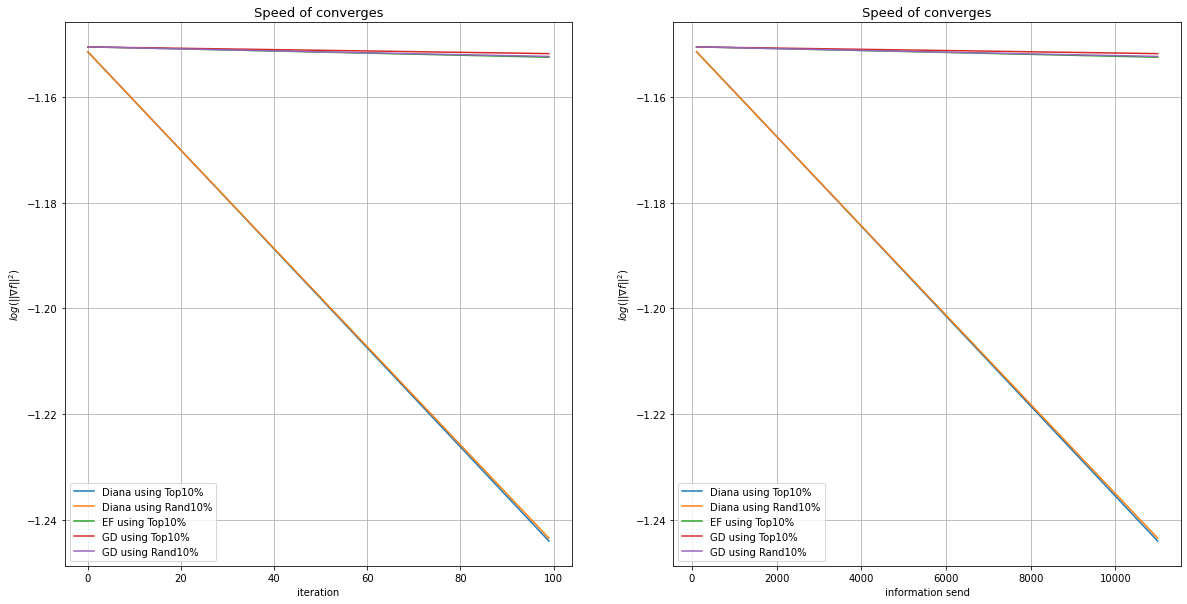

In [284]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  

ax[0].set_title('Speed of converges', fontsize=13) 
ax[1].set_title('Speed of converges', fontsize=13) 
ax[0].grid() 
ax[1].grid()  
ax[0].set_xlabel('iteration', fontsize=10) 
ax[0].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=10) 
ax[1].set_xlabel('information send', fontsize=10) 
ax[1].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=10)  

ax[0].plot(range(0, diana_top_k.max_iter, 1), np.log(diana_top_k.grad_history), label = 'Diana using Top10%')
ax[0].plot(range(0, diana_rand_k.max_iter, 1), np.log(diana_rand_k.grad_history), label = 'Diana using Rand10%') 
ax[0].plot(range(0, ef_top_k.max_iter, 1), np.log(ef_top_k.grad_history), label = 'EF using Top10%')  
#ax[0].plot(range(0, ef_rand_k.max_iter, 1), np.log(ef_rand_k.grad_history), label = 'EF using Rand10%')  
ax[0].plot(range(0, gd_top_k.max_iter, 1), np.log(gd_top_k.grad_history), label = 'GD using Top10%') 
ax[0].plot(range(0, gd_rand_k.max_iter, 1), np.log(gd_rand_k.grad_history), label = 'GD using Rand10%')   
ax[0].legend()

ax[1].plot(diana_top_k.information_send, np.log(diana_top_k.grad_history), label = 'Diana using Top10%')
ax[1].plot(diana_rand_k.information_send, np.log(diana_rand_k.grad_history), label = 'Diana using Rand10%') 
ax[1].plot(ef_top_k.information_send, np.log(ef_top_k.grad_history), label = 'EF using Top10%')  
#ax[1].plot(ef_rand_k.information_send, np.log(ef_rand_k.grad_history), label = 'EF using Rand10%')  
ax[1].plot(gd_top_k.information_send, np.log(gd_top_k.grad_history), label = 'GD using Top10%') 
ax[1].plot(gd_rand_k.information_send, np.log(gd_rand_k.grad_history), label = 'GD using Rand10%') 
ax[1].legend() 

## Как видим DIANA полностью решает вопрос с сигмой со звездочкой(с семинара) и позволяет нам быстрее сходится чем остальные методы(с линейной скоростью). На данной задаче можно увидеть, что как раз не равная нулю сигма со звездочкой приводит к тому что EF и GD не сильно отличаются

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [236]:
class EF21: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg): 
        self.data_worker_x = data_worker_x
        self.data_worker_y = data_worker_y 
        self.max_iter = max_iter  
        self.lr = lr 
        self.w = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name = name
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d) 
        self.reg = reg 
        
    def fit(self, X_train, y_train): 
        self.w = np.zeros(self.d) 
        h = np.zeros((self.workers, self.d))   
        g = np.zeros(self.d)  
        information = 0
        
        for i in range(self.workers): 
            tmp_h = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg)
            h[i] = Compression(self.name, self.percents, tmp_h, self.d)  
            g = g + h[i]   
        g /= self.workers   
        
        full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
        self.grad_history.append(np.linalg.norm(full_g)**2) 
        self.information_send.append(information)
        
        for i in range(self.max_iter): 
            self.w = self.w - self.lr * g  
            for j in range(self.workers):  
                tmp_h = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, self.reg) 
                c = Compression(self.name, self.percents, tmp_h - h[j], self.d) 
                h[j] = h[j] + c  
                g = g + c / self.workers   
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2)  
            information += self.k * self.workers
            self.information_send.append(information) 

In [219]:
from scipy.stats import bernoulli 

In [285]:
class MARINA: 
        def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name, percents, d, reg, p): 
            self.data_worker_x = data_worker_x
            self.data_worker_y = data_worker_y 
            self.max_iter = max_iter  
            self.lr = lr 
            self.w = None 
            self.information_send = [] 
            self.grad_history = [] 
            self.workers = workers 
            self.name = name
            self.percents = percents  
            self.d = d 
            self.k = int(percents * d) 
            self.reg = reg  
            self.p = p  
    
        def fit(self, X_train, y_train):  
            self.w = np.zeros(self.d) 
            g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)  
            h = np.zeros((self.workers, self.d))  
            g_worker = np.zeros((self.workers, self.d)) 
            information = 0 
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            self.information_send.append(information) 
            
            for i in range(self.workers): 
                g_worker[i] = grad(self.data_worker_x[i], self.data_worker_y[i],
                                  self.data_worker_x[i].shape[0], self.w, self.reg) 
                
            for i in range(self.max_iter): 
                s = np.zeros(self.d)
                c = bernoulli.rvs(self.p, size=1) 
                for j in range(self.workers): 
                    self.w = self.w - self.lr * g   
                    tmp_h = grad(self.data_worker_x[j], self.data_worker_y[j], 
                                    self.data_worker_x[j].shape[0], self.w, self.reg) 
                    if(c == 1): 
                        h[j] = tmp_h 
                    else: 
                        h[j] = g + Compression(self.name, self.percents, tmp_h - g_worker[j], self.d)  
                    g_worker[j] = tmp_h   
                    s = s + h[j] 
                    
                g = s / self.workers 
                if(c == 1): 
                    information += self.workers * self.d  
                else: 
                    information += self.workers * self.k 
                full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg) 
                self.grad_history.append(np.linalg.norm(full_g)**2) 
                self.information_send.append(information) 

In [286]:
marina_rand_k = MARINA(workers_x, workers_y, 10, 1/(4 * L), 10**2, 'RandK', 0.1, d, L/1000, 0.1) 

In [287]:
ef21_top_k = EF21(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'TopK', 0.1, d, L/1000) 
ef21_rand_k = EF21(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'RandK', 0.1, d, L/1000) 

In [288]:
marina_rand_k.fit(X_train, y_train) 

/tmp/ipykernel_37268/1190848947.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  g_worker[i] = grad(self.data_worker_x[i], self.data_worker_y[i],
/tmp/ipykernel_37268/2053126653.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]
/tmp/ipykernel_37268/1190848947.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  h[j] = g + Compression(self.name, self.percents, tmp_h - g_worker[j], self.d)
/tmp/ipykernel_37268/1190848947.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  g_worker[j] = tmp_h
/tmp/ipykernel_37268/1190848947.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  h[j] = tmp_h


In [289]:
ef21_top_k.fit(X_train, y_train) 
ef21_rand_k.fit(X_train, y_train)

/tmp/ipykernel_37268/3962941089.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  new_vector[indices] = vector[indices]
/tmp/ipykernel_37268/1189897838.py:4: RuntimeWarning: overflow encountered in exp
  g = g + (-batch_y[j] * batch_x[j]) / (1 + np.exp(batch_y[j] * np.dot(w.T, batch_x[j])))


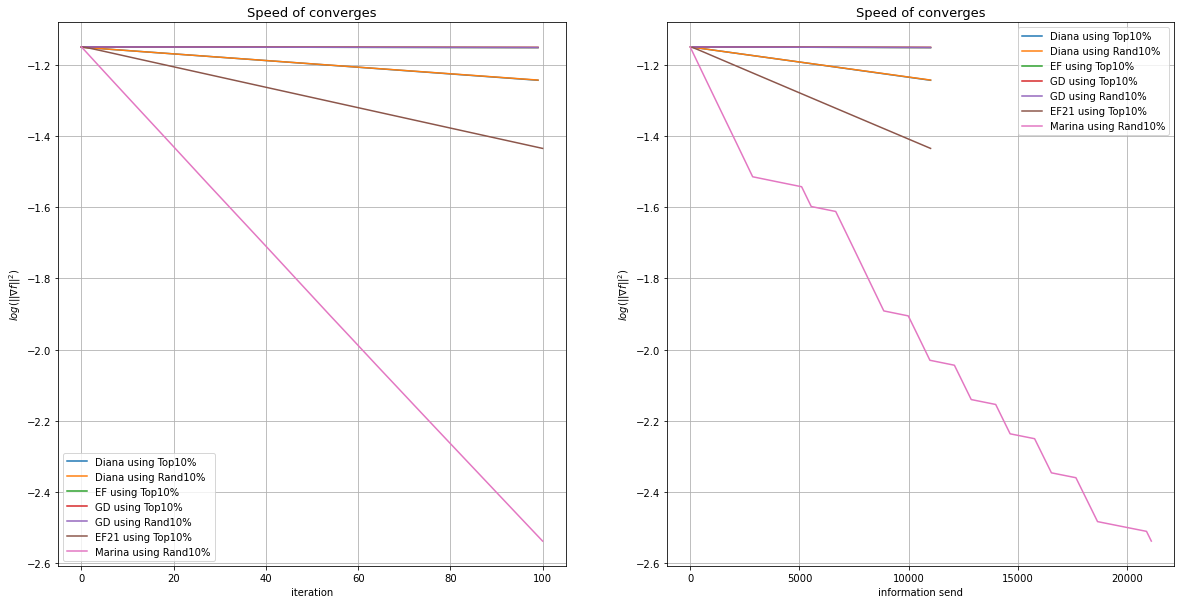

In [290]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  

ax[0].set_title('Speed of converges', fontsize=13) 
ax[1].set_title('Speed of converges', fontsize=13) 
ax[0].grid() 
ax[1].grid()  
ax[0].set_xlabel('iteration', fontsize=10) 
ax[0].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=10) 
ax[1].set_xlabel('information send', fontsize=10) 
ax[1].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=10)  

ax[0].plot(range(0, diana_top_k.max_iter, 1), np.log(diana_top_k.grad_history), label = 'Diana using Top10%')
ax[0].plot(range(0, diana_rand_k.max_iter, 1), np.log(diana_rand_k.grad_history), label = 'Diana using Rand10%') 
ax[0].plot(range(0, ef_top_k.max_iter, 1), np.log(ef_top_k.grad_history), label = 'EF using Top10%')  
#ax[0].plot(range(0, ef_rand_k.max_iter, 1), np.log(ef_rand_k.grad_history), label = 'EF using Rand10%')  
ax[0].plot(range(0, gd_top_k.max_iter, 1), np.log(gd_top_k.grad_history), label = 'GD using Top10%') 
ax[0].plot(range(0, gd_rand_k.max_iter, 1), np.log(gd_rand_k.grad_history), label = 'GD using Rand10%')  
ax[0].plot(range(0, ef21_top_k.max_iter + 1, 1), np.log(ef21_top_k.grad_history), label = 'EF21 using Top10%') 
#ax[0].plot(range(0, ef21_rand_k.max_iter + 1, 1), np.log(ef21_rand_k.grad_history), label = 'EF21 using Rand10%') 
ax[0].plot(range(0, marina_rand_k.max_iter + 1, 1), np.log(marina_rand_k.grad_history), label = 'Marina using Rand10%')
ax[0].legend()

ax[1].plot(diana_top_k.information_send, np.log(diana_top_k.grad_history), label = 'Diana using Top10%')
ax[1].plot(diana_rand_k.information_send, np.log(diana_rand_k.grad_history), label = 'Diana using Rand10%') 
ax[1].plot(ef_top_k.information_send, np.log(ef_top_k.grad_history), label = 'EF using Top10%')  
#ax[1].plot(ef_rand_k.information_send, np.log(ef_rand_k.grad_history), label = 'EF using Rand10%')  
ax[1].plot(gd_top_k.information_send, np.log(gd_top_k.grad_history), label = 'GD using Top10%') 
ax[1].plot(gd_rand_k.information_send, np.log(gd_rand_k.grad_history), label = 'GD using Rand10%')  
ax[1].plot(ef21_top_k.information_send, np.log(ef21_top_k.grad_history), label = 'EF21 using Top10%')  
ax[1].plot(marina_rand_k.information_send, np.log(marina_rand_k.grad_history), label = 'Marina using Rand10%')
#ax[1].plot(ef21_rand_k.information_send, np.log(ef21_rand_k.grad_history), label = 'EF21 using Rand10%')
ax[1].legend() 

## Как видно из графиков MARINA сильно обходит своих соперников по скорости сходимости, также стоит отметить EF21, который также показывает себя лучше остальных алгоритмов изспользую Top10% в качестве оператора компрессии.

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

# Пункт 1

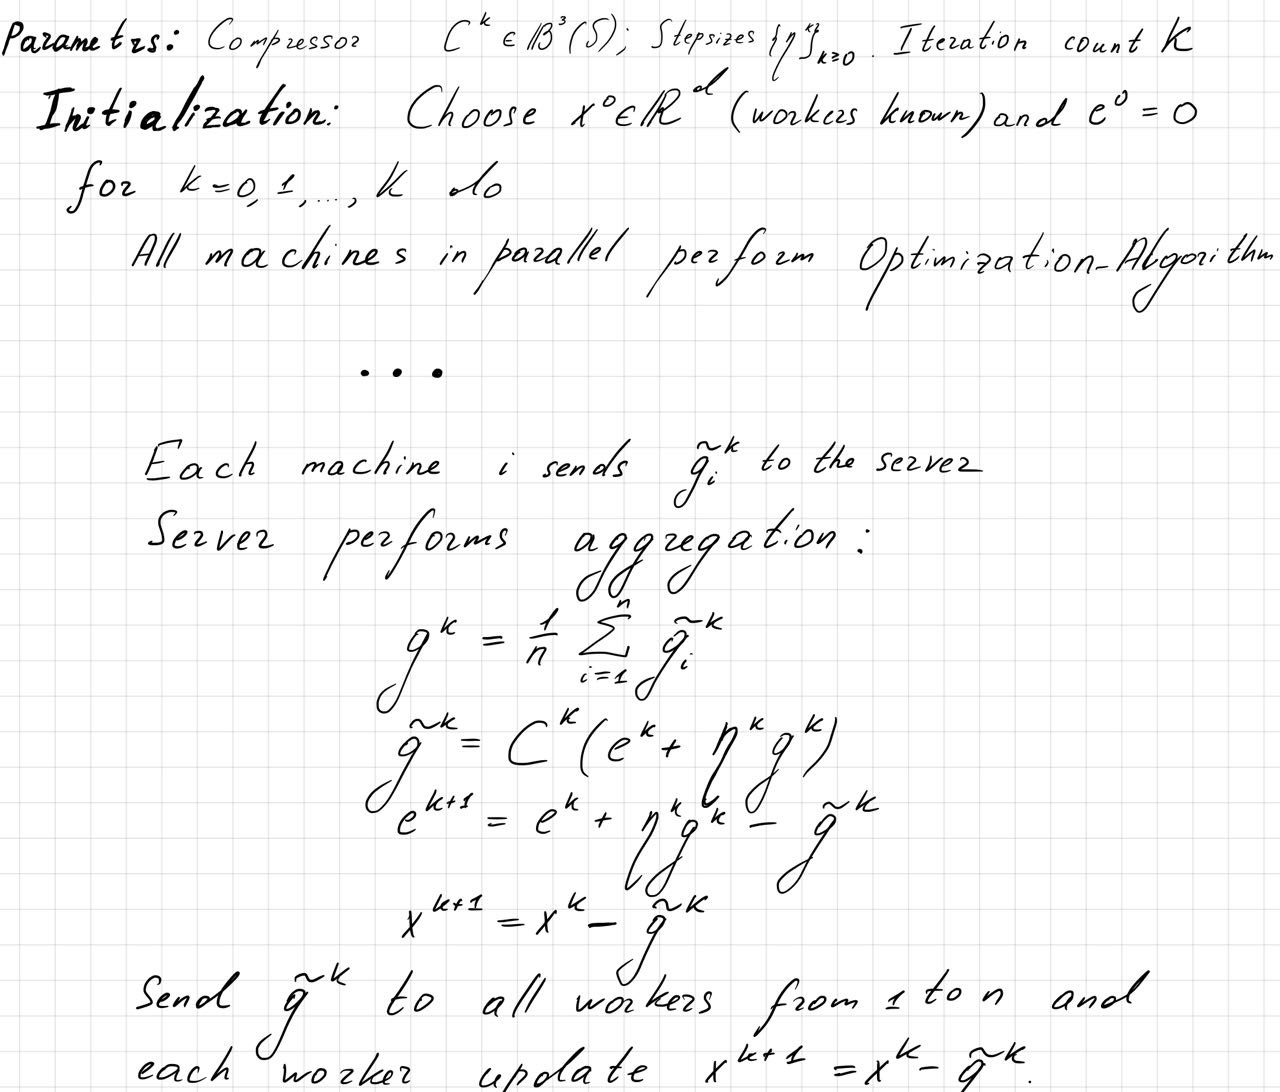

## Чтобы сделать какие-то выводы по тому нужно ли использовать error-feedback  на сервере с оператором сжатия Top10%, проведем эскперимент. А именно напишем стандартный алгоритм EF21 и EF21 с error-feedback на сервере и посмотрим, кто себя лучше покажет. 

In [388]:
class ServerEF: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name_to_clients,
                     name_to_server, percents, d, reg): 
        self.data_worker_x = data_worker_x
        self.data_worker_y = data_worker_y 
        self.max_iter = max_iter  
        self.lr = lr 
        self.w = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name_to_clients = name_to_clients 
        self.name_to_server = name_to_server 
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d) 
        self.reg = reg 
        
    def fit(self, X_train, y_train): 
        self.w = np.zeros(self.d) 
        h = np.zeros((self.workers, self.d))   
        g = np.zeros(self.d)  
        e = 0
        information = 0
        
        for i in range(self.workers): 
            tmp_h = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg)
            h[i] = Compression(self.name_to_server, self.percents, tmp_h, self.d)  
            g = g + h[i]   
        g /= self.workers   
        
        full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
        self.grad_history.append(np.linalg.norm(full_g)**2) 
        self.information_send.append(information)
        
        for i in range(self.max_iter): 
            g_compressed = Compression(self.name_to_clients, self.percents, e + self.lr * g, self.d) 
            e = e + self.lr * g - g_compressed 
            self.w = self.w - g_compressed  
            information += self.workers * self.k 
            for j in range(self.workers):  
                tmp_h = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, self.reg) 
                c = Compression(self.name_to_server, self.percents, tmp_h - h[j], self.d) 
                h[j] = h[j] + c  
                g = g + c / self.workers   
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2)  
            information += self.k * self.workers
            self.information_send.append(information) 

## На мой взгляд лучше всего себя показали DIANA, EF21, MARINA. С ними я и буду дальше работать.

## Значит каждый worker хранит у себя тоже эти самые иксы, получается эти воркеры делают у себя локальный UPDATE, тем самым мы избегаем пересылки полного вектора x или полного градиента на workers 

In [375]:
class UpdateDIANA:  
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name_to_clients,
                 name_to_server, percents, d, reg, alpha): 
        self.data_worker_x = data_worker_x 
        self.data_worker_y = data_worker_y
        self.workers = workers 
        self.lr = lr 
        self.max_iter = max_iter   
        self.name_to_clients = name_to_clients
        self.name_to_server = name_to_server 
        self.percents = percents 
        self.d = d 
        self.information_send = [] 
        self.grad_history = [] 
        self.w = None 
        self.reg = reg   
        self.alpha = alpha  
        self.k = self.percents * self.d
        #на самом деле тут должно быть в (workers + 1) раза памяти больше ибо храним h и на сервере 
        #и на компьютерах 
        
    def fit(self, X_train, y_train): 
        self.w = np.zeros(self.d)   
        h = np.zeros((self.workers, self.d)) 
        k = int(self.percents * d) 
        information = 0 
        for i in range(self.workers): 
            h[i] = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg) 
        
        for i in range(self.max_iter):  
            g = np.zeros(self.d)  
            for j in range(self.workers): 
                delta = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, reg) 
                delta = delta - h[j]
                delta_compressed = Compression(self.name_to_server, self.percents, delta, self.d)  
                g += h[j] + delta_compressed
                h[j] += self.alpha * delta_compressed 
            
            self.w = self.w - self.lr * Compression(self.name_to_clients, self.percents, 1/self.workers * g, self.d) 
            information += self.k * self.workers
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            information += k * self.workers 
            self.information_send.append(information)

In [376]:
class UpdateEF21: 
    def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name_to_clients,
                     name_to_server, percents, d, reg): 
        self.data_worker_x = data_worker_x
        self.data_worker_y = data_worker_y 
        self.max_iter = max_iter  
        self.lr = lr 
        self.w = None 
        self.information_send = [] 
        self.grad_history = [] 
        self.workers = workers 
        self.name_to_clients = name_to_clients 
        self.name_to_server = name_to_server 
        self.percents = percents  
        self.d = d 
        self.k = int(percents * d) 
        self.reg = reg 
        
    def fit(self, X_train, y_train): 
        self.w = np.zeros(self.d) 
        h = np.zeros((self.workers, self.d))   
        g = np.zeros(self.d)  
        information = 0
        
        for i in range(self.workers): 
            tmp_h = grad(self.data_worker_x[i], self.data_worker_y[i], self.data_worker_x[i].shape[0], self.w, self.reg)
            h[i] = Compression(self.name_to_server, self.percents, tmp_h, self.d)  
            g = g + h[i]   
        g /= self.workers   
        
        full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
        self.grad_history.append(np.linalg.norm(full_g)**2) 
        self.information_send.append(information)
        
        for i in range(self.max_iter): 
            self.w = self.w - self.lr * Compression(self.name_to_clients, self.percents, g, self.d)   
            information += self.workers * self.k 
            for j in range(self.workers):  
                tmp_h = grad(self.data_worker_x[j], self.data_worker_y[j], self.data_worker_x[j].shape[0], self.w, self.reg) 
                c = Compression(self.name_to_server, self.percents, tmp_h - h[j], self.d) 
                h[j] = h[j] + c  
                g = g + c / self.workers   
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2)  
            information += self.k * self.workers
            self.information_send.append(information) 

In [377]:
class UpdateMARINA: 
        def __init__(self, data_worker_x, data_worker_y, workers, lr, max_iter, name_to_clients,
                     name_to_server, percents, d, reg, p): 
            self.data_worker_x = data_worker_x
            self.data_worker_y = data_worker_y 
            self.max_iter = max_iter  
            self.lr = lr 
            self.w = None 
            self.information_send = [] 
            self.grad_history = [] 
            self.workers = workers 
            self.name_to_clients = name_to_clients 
            self.name_to_server = name_to_server 
            self.percents = percents  
            self.d = d 
            self.k = int(percents * d) 
            self.reg = reg  
            self.p = p  
    
        def fit(self, X_train, y_train):  
            self.w = np.zeros(self.d) 
            g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)  
            h = np.zeros((self.workers, self.d))  
            g_worker = np.zeros((self.workers, self.d)) 
            information = 0 
            full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg)
            self.grad_history.append(np.linalg.norm(full_g)**2) 
            self.information_send.append(information) 
            
            for i in range(self.workers): 
                g_worker[i] = grad(self.data_worker_x[i], self.data_worker_y[i],
                                  self.data_worker_x[i].shape[0], self.w, self.reg) 
                
            for i in range(self.max_iter): 
                s = np.zeros(self.d)
                c = bernoulli.rvs(self.p, size=1) 
                for j in range(self.workers): 
                    self.w = self.w - self.lr * Compression(self.name_to_clients, self.percents, g, self.d) 
                    information += self.k * self.workers
                    tmp_h = grad(self.data_worker_x[j], self.data_worker_y[j], 
                                    self.data_worker_x[j].shape[0], self.w, self.reg) 
                    if(c == 1): 
                        h[j] = tmp_h 
                    else: 
                        h[j] = g + Compression(self.name_to_server, self.percents, tmp_h - g_worker[j], self.d)  
                    g_worker[j] = tmp_h   
                    s = s + h[j] 
                    
                g = s / self.workers 
                if(c == 1): 
                    information += self.workers * self.d  
                else: 
                    information += self.workers * self.k 
                full_g = grad(X_train, y_train, X_train.shape[0], self.w, self.reg) 
                self.grad_history.append(np.linalg.norm(full_g)**2) 
                self.information_send.append(information) 

In [378]:
diana_top_k = UpdateDIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'TopK', 'TopK', 0.1, d, L/1000, 1/11) 
diana_rand_k = UpdateDIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'RandK', 'RandK', 0.1, d, L/1000, 1/11) 
diana_top_rand_k = UpdateDIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'TopK', 'RandK', 0.1, d, L/1000, 1/11) 
diana_rand_top_k = UpdateDIANA(workers_x, workers_y, 10, 1/(6 * L), 10**2, 'RandK', 'TopK', 0.1, d, L/1000, 1/11) 

In [379]:
marina_top_k = UpdateMARINA(workers_x, workers_y, 10, 1/(4 * L), 10**2, 'TopK', 'TopK', 0.1, d, L/1000, 0.1) 
marina_rand_k = UpdateMARINA(workers_x, workers_y, 10, 1/(4 * L), 10**2, 'RandK', 'RandK', 0.1, d, L/1000, 0.1) 
marina_top_rand_k = UpdateMARINA(workers_x, workers_y, 10, 1/(4 * L), 10**2, 'TopK', 'RandK', 0.1, d, L/1000, 0.1)  
marina_rand_top_k = UpdateMARINA(workers_x, workers_y, 10, 1/(4 * L), 10**2, 'RandK', 'TopK', 0.1, d, L/1000, 0.1)  

In [380]:
ef21_top_k = UpdateEF21(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'TopK', 'TopK', 0.1, d, L/1000) 
ef21_rand_k = UpdateEF21(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'RandK', 'RandK', 0.1, d, L/1000) 
ef21_top_rand_k = UpdateEF21(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'TopK', 'RandK', 0.1, d, L/1000) 
ef21_rand_top_k = UpdateEF21(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'RandK', 'TopK', 0.1, d, L/1000) 

In [381]:
diana_top_k.fit(X_train, y_train) 
diana_rand_k.fit(X_train, y_train) 
diana_top_rand_k.fit(X_train, y_train) 
diana_rand_top_k.fit(X_train, y_train)

In [382]:
marina_top_k.fit(X_train, y_train)
marina_rand_k.fit(X_train, y_train) 
marina_top_rand_k.fit(X_train, y_train) 
marina_rand_top_k.fit(X_train, y_train)

In [383]:
ef21_top_k.fit(X_train, y_train) 
#ef21_rand_k.fit(X_train, y_train) 
#ef21_top_rand_k.fit(X_train, y_train) 
ef21_rand_top_k.fit(X_train, y_train)

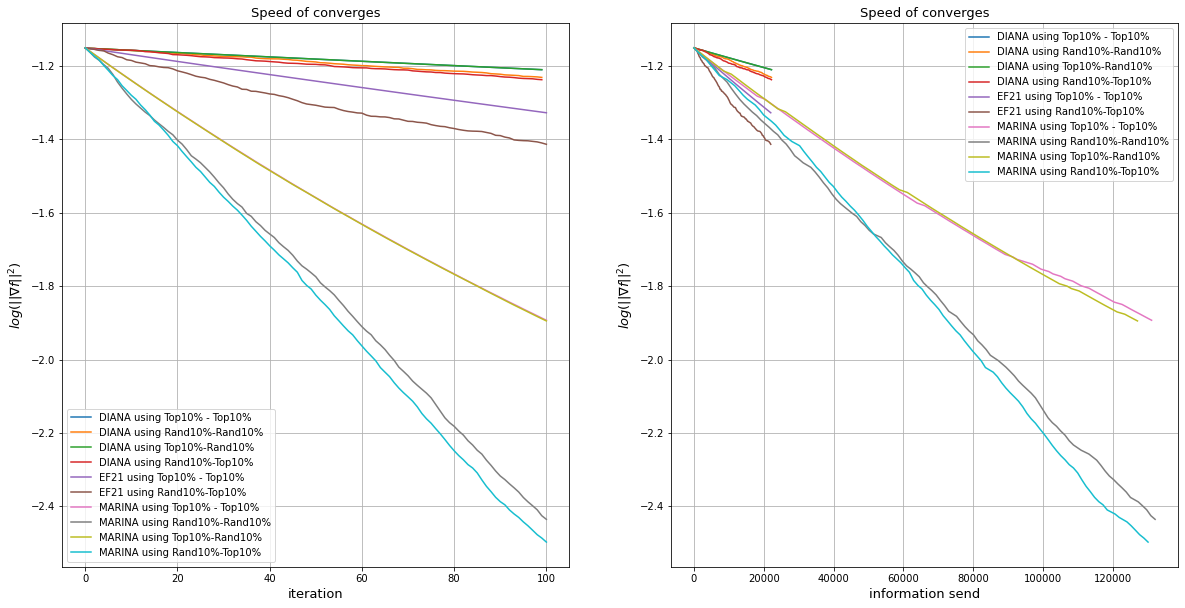

In [387]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  

ax[0].set_title('Speed of converges', fontsize=13) 
ax[1].set_title('Speed of converges', fontsize=13) 
ax[0].grid() 
ax[1].grid()  
ax[0].set_xlabel('iteration', fontsize=13) 
ax[0].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=13) 
ax[1].set_xlabel('information send', fontsize=13) 
ax[1].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=13)  

ax[0].plot(range(0, diana_top_k.max_iter, 1), np.log(diana_top_k.grad_history), label = 'DIANA using Top10% - Top10%') 
ax[0].plot(range(0, diana_rand_k.max_iter, 1), np.log(diana_rand_k.grad_history), label = 'DIANA using Rand10%-Rand10%') 
ax[0].plot(range(0, diana_top_rand_k.max_iter, 1), np.log(diana_top_rand_k.grad_history), label = 'DIANA using Top10%-Rand10%')  
ax[0].plot(range(0, diana_rand_top_k.max_iter, 1), np.log(diana_rand_top_k.grad_history), label = 'DIANA using Rand10%-Top10%')  

ax[0].plot(range(0, ef21_top_k.max_iter + 1, 1), np.log(ef21_top_k.grad_history), label = 'EF21 using Top10% - Top10%') 
#ax[0].plot(range(0, ef21_rand_k.max_iter + 1, 1), np.log(ef21_rand_k.grad_history), label = 'EF21 using Rand10%-Rand10%')  
#ax[0].plot(range(0, ef21_top_rand_k.max_iter + 1, 1), np.log(ef21_top_rand_k.grad_history), label = 'EF21 using Top10%-Rand10%')  
ax[0].plot(range(0, ef21_rand_top_k.max_iter + 1, 1), np.log(ef21_rand_top_k.grad_history), label = 'EF21 using Rand10%-Top10%')  

ax[0].plot(range(0, marina_top_k.max_iter + 1, 1), np.log(marina_top_k.grad_history), label = 'MARINA using Top10% - Top10%') 
ax[0].plot(range(0, marina_rand_k.max_iter + 1, 1), np.log(marina_rand_k.grad_history), label = 'MARINA using Rand10%-Rand10%')  
ax[0].plot(range(0, marina_top_rand_k.max_iter + 1, 1), np.log(marina_top_rand_k.grad_history), label = 'MARINA using Top10%-Rand10%')  
ax[0].plot(range(0, marina_rand_top_k.max_iter + 1, 1), np.log(marina_rand_top_k.grad_history), label = 'MARINA using Rand10%-Top10%')  
ax[0].legend() 

ax[1].plot(diana_top_k.information_send, np.log(diana_top_k.grad_history), label = 'DIANA using Top10% - Top10%') 
ax[1].plot(diana_rand_k.information_send, np.log(diana_rand_k.grad_history), label = 'DIANA using Rand10%-Rand10%') 
ax[1].plot(diana_top_rand_k.information_send, np.log(diana_top_rand_k.grad_history), label = 'DIANA using Top10%-Rand10%')  
ax[1].plot(diana_rand_top_k.information_send, np.log(diana_rand_top_k.grad_history), label = 'DIANA using Rand10%-Top10%')  

ax[1].plot(ef21_top_k.information_send, np.log(ef21_top_k.grad_history), label = 'EF21 using Top10% - Top10%') 
#ax[1].plot(ef21_rand_k.information_send, np.log(ef21_rand_k.grad_history), label = 'EF21 using Rand10%-Rand10%')  
#ax[1].plot(ef21_top_rand_k.information_send, np.log(ef21_top_rand_k.grad_history), label = 'EF21 using Top10%-Rand10%')  
ax[1].plot(ef21_rand_top_k.information_send, np.log(ef21_rand_top_k.grad_history), label = 'EF21 using Rand10%-Top10%')  

ax[1].plot(marina_top_k.information_send, np.log(marina_top_k.grad_history), label = 'MARINA using Top10% - Top10%') 
ax[1].plot(marina_rand_k.information_send, np.log(marina_rand_k.grad_history), label = 'MARINA using Rand10%-Rand10%')  
ax[1].plot(marina_top_rand_k.information_send, np.log(marina_top_rand_k.grad_history), label = 'MARINA using Top10%-Rand10%')  
ax[1].plot(marina_rand_top_k.information_send, np.log(marina_rand_top_k.grad_history), label = 'MARINA using Rand10%-Top10%')  

ax[1].legend()

# 2, 3 пункт:
## Как итог мы видим, что MARINA ведет себя лучше всех, если смотреть на график итераций. Также наилучшим образом показывает себя MARINA, которая отсылает клиентам сжатый градиент с помощью Rand10%, а на сервер с помощью Top10%. 

## А вот если смотреть на пересылаемую информацию, то лучше всего себя показывают не MARINA, a EF21, использующий  для пересылки клиентам и серверу оператор сжатия Top10% 

## Error Feedback на сервере при этом мы не испоьзовали. 

##  Вернемся к 1 пункту и посмотри на результаты 

In [389]:
server_top_k = ServerEF(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'TopK', 'TopK', 0.1, d, L/1000)
ef21_top_k = UpdateEF21(workers_x, workers_y, 10, 1/(L * (1 + np.sqrt(0.9))), 10**2, 'TopK', 'TopK', 0.1, d, L/1000)

In [390]:
server_top_k.fit(X_train, y_train) 
ef21_top_k.fit(X_train, y_train)

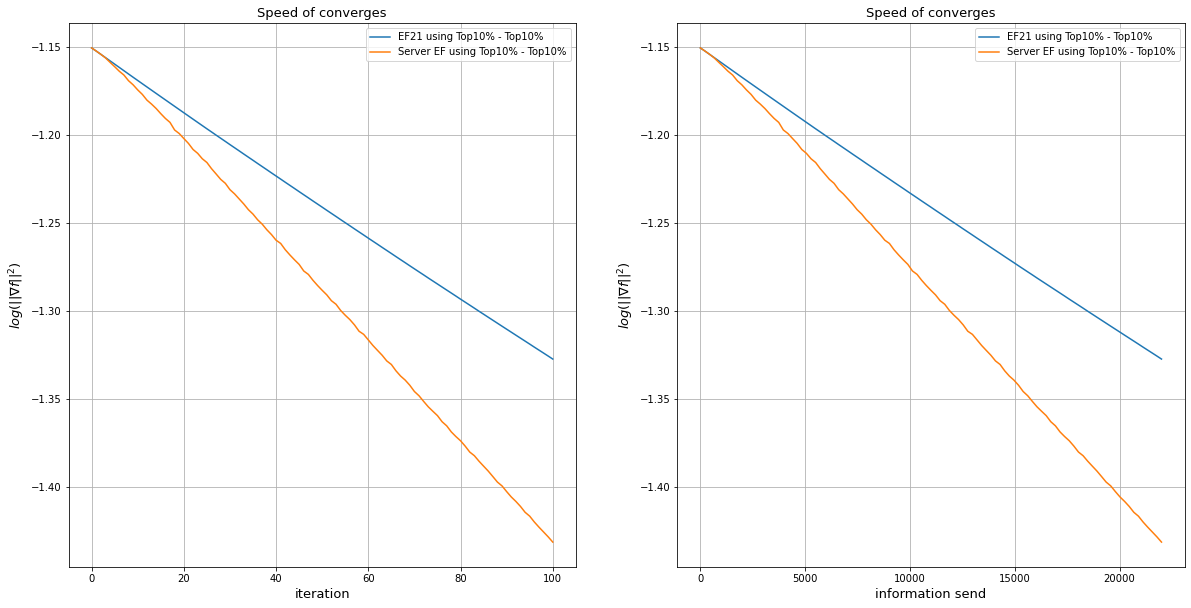

In [393]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  

ax[0].set_title('Speed of converges', fontsize=13) 
ax[1].set_title('Speed of converges', fontsize=13) 
ax[0].grid() 
ax[1].grid()  
ax[0].set_xlabel('iteration', fontsize=13) 
ax[0].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=13) 
ax[1].set_xlabel('information send', fontsize=13) 
ax[1].set_ylabel(r'$log(||\nabla f||^{2})$', fontsize=13) 
 
ax[0].plot(range(0, ef21_top_k.max_iter + 1, 1), np.log(ef21_top_k.grad_history), label = 'EF21 using Top10% - Top10%') 
ax[0].plot(range(0, server_top_k.max_iter + 1, 1), np.log(server_top_k.grad_history), label = 'Server EF using Top10% - Top10%')
ax[0].legend()  

ax[1].plot(ef21_top_k.information_send, np.log(ef21_top_k.grad_history), label = 'EF21 using Top10% - Top10%')
ax[1].plot(server_top_k.information_send, np.log(server_top_k.grad_history), label = 'Server EF using Top10% - Top10%') 
ax[1].legend()

## Видим, что error-feedback на сервере хорошо улучшает существующий алгоритм EF21 и дает заметный выигрыш в сходимости.